# Лабораторная работа №1: Метод K ближайших соседей (KNN)

## Цель работы

Познакомиться с методом K ближайших соседей для задач классификации и регрессии, реализовать его с помощью библиотеки scikit-learn и самостоятельно на Python/NumPy.

## Используемые датасеты

### 1. Credit Card Fraud Detection (Классификация)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Задача**: Обнаружение мошеннических транзакций по кредитным картам
- **Практическое применение**: Финансовая безопасность, предотвращение мошенничества в реальном времени
- **Особенности**: Сильно несбалансированный датасет (fraud ~0.17%)

### 2. Student Performance Dataset (Регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set)
- **Задача**: Предсказание итоговой оценки студента (G3) на основе социальных, демографических и учебных факторов
- **Практическое применение**: Образовательная аналитика, раннее выявление студентов группы риска
- **Особенности**: Смешанные типы признаков (числовые и категориальные)

## Выбор метрик

### Классификация
- **ROC-AUC Score**: Основная метрика для несбалансированных данных
- **Precision**: Важна для минимизации ложных срабатываний
- **Recall**: Важна для обнаружения максимального количества мошенничеств
- **F1-Score**: Баланс между Precision и Recall

### Регрессия
- **R² Score**: Показывает долю объясненной дисперсии
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка в баллах
- **RMSE (Root Mean Squared Error)**: Штрафует большие ошибки сильнее

## 1. Импорт библиотек

Импортируем все необходимые библиотеки для работы с данными, построения моделей и визуализации.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn для моделей и метрик
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

# Для работы с несбалансированными данными
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Фиксируем random seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Загрузка и первичный анализ данных (EDA)

### 2.1 Загрузка датасетов

In [2]:
# Загрузка датасета для классификации (Credit Card Fraud)
df_fraud = pd.read_csv('data/creditcard.csv')
print("=" * 80)
print("ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ: Credit Card Fraud Detection")
print("=" * 80)
print(f"Размер датасета: {df_fraud.shape}")
print(f"Количество признаков: {df_fraud.shape[1] - 1}")
print(f"Количество образцов: {df_fraud.shape[0]}")
print("\nПервые 5 строк:")
display(df_fraud.head())

print("\n" + "=" * 80)
# Загрузка датасета для регрессии (Student Performance)
df_student = pd.read_csv('data/student-por.csv')
print("ДАТАСЕТ ДЛЯ РЕГРЕССИИ: Student Performance")
print("=" * 80)
print(f"Размер датасета: {df_student.shape}")
print(f"Количество признаков: {df_student.shape[1] - 1}")
print(f"Количество образцов: {df_student.shape[0]}")
print("\nПервые 5 строк:")
display(df_student.head())


ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ: Credit Card Fraud Detection
Размер датасета: (284807, 31)
Количество признаков: 30
Количество образцов: 284807

Первые 5 строк:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



ДАТАСЕТ ДЛЯ РЕГРЕССИИ: Student Performance
Размер датасета: (649, 33)
Количество признаков: 32
Количество образцов: 649

Первые 5 строк:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


### 2.2 Анализ датасета классификации (Credit Card Fraud)

Изучим структуру данных, проверим наличие пропусков и распределение целевой переменной.

In [3]:
# Информация о датасете
print("Информация о датасете:")
print(df_fraud.info())

# Проверка на пропуски
print("\n" + "=" * 80)
print("Проверка на пропущенные значения:")
missing_fraud = df_fraud.isnull().sum()
if missing_fraud.sum() == 0:
    print("✓ Пропущенные значения отсутствуют")
else:
    print(missing_fraud[missing_fraud > 0])

# Статистика по целевой переменной
print("\n" + "=" * 80)
print("Распределение классов (Class):")
class_dist = df_fraud['Class'].value_counts()
print(class_dist)
print(f"\nДоля мошеннических транзакций: {class_dist[1] / len(df_fraud) * 100:.3f}%")
print(f"Соотношение классов (Normal:Fraud): {class_dist[0]}:{class_dist[1]} = {class_dist[0]/class_dist[1]:.1f}:1")

# Статистические характеристики
print("\n" + "=" * 80)
print("Основные статистические характеристики:")
display(df_fraud.describe().T)


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.384974e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.494498e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.414189e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


### 2.3 Визуализация датасета классификации

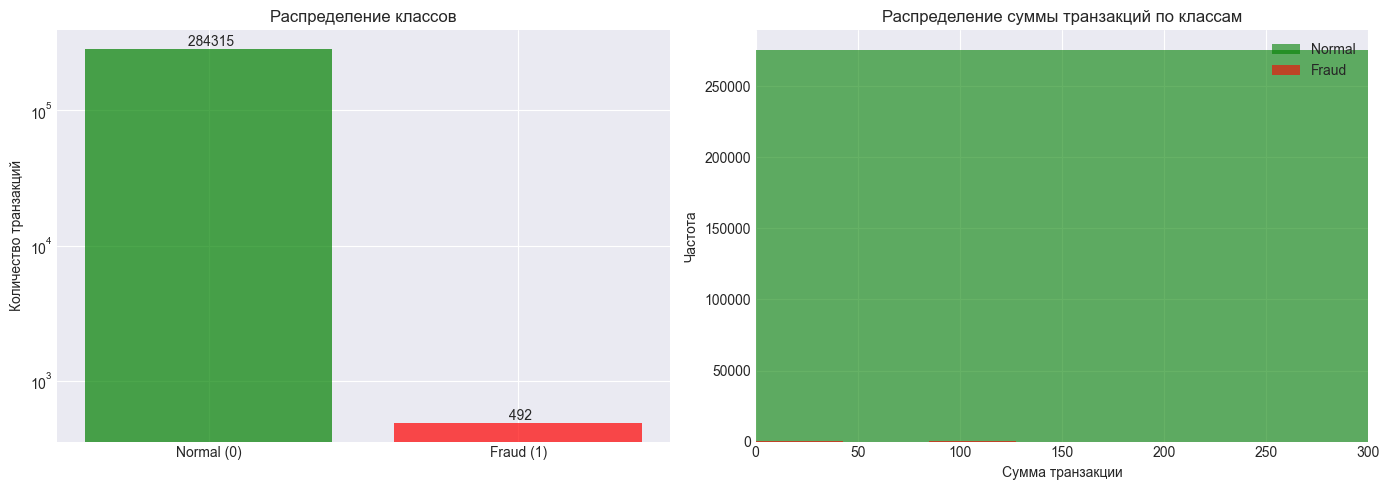

Топ-10 признаков по корреляции с целевой переменной Class:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


In [4]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Распределение классов
class_counts = df_fraud['Class'].value_counts()
axes[0].bar(['Normal (0)', 'Fraud (1)'], class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Количество транзакций')
axes[0].set_title('Распределение классов')
axes[0].set_yscale('log')  # Логарифмическая шкала из-за дисбаланса
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f' {v}', va='bottom', ha='center')

# График 2: Распределение Amount для разных классов
axes[1].hist(df_fraud[df_fraud['Class']==0]['Amount'], bins=50, alpha=0.6, label='Normal', color='green')
axes[1].hist(df_fraud[df_fraud['Class']==1]['Amount'], bins=50, alpha=0.6, label='Fraud', color='red')
axes[1].set_xlabel('Сумма транзакции')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение суммы транзакций по классам')
axes[1].legend()
axes[1].set_xlim(0, 300)  # Ограничиваем для лучшей видимости

plt.tight_layout()
plt.show()

# Корреляция некоторых признаков с целевой переменной
print("Топ-10 признаков по корреляции с целевой переменной Class:")
correlations = df_fraud.corr()['Class'].abs().sort_values(ascending=False)
print(correlations[1:11])  # Исключаем саму Class


### 2.4 Анализ датасета регрессии (Student Performance)

Изучим структуру данных студентов, проверим типы признаков и распределение целевой переменной.

In [5]:
# Информация о датасете
print("Информация о датасете:")
print(df_student.info())

# Проверка на пропуски
print("\n" + "=" * 80)
print("Проверка на пропущенные значения:")
missing_student = df_student.isnull().sum()
if missing_student.sum() == 0:
    print("✓ Пропущенные значения отсутствуют")
else:
    print(missing_student[missing_student > 0])

# Разделение признаков на числовые и категориальные
numeric_cols = df_student.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_student.select_dtypes(include=['object']).columns.tolist()

print("\n" + "=" * 80)
print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")
print(f"\nКатегориальные признаки ({len(categorical_cols)}): {categorical_cols}")

# Статистика по целевой переменной G3
print("\n" + "=" * 80)
print("Статистика по целевой переменной G3 (финальная оценка):")
print(df_student['G3'].describe())
print(f"\nМинимальная оценка: {df_student['G3'].min()}")
print(f"Максимальная оценка: {df_student['G3'].max()}")
print(f"Средняя оценка: {df_student['G3'].mean():.2f}")
print(f"Медианная оценка: {df_student['G3'].median():.2f}")


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null   

### 2.5 Визуализация датасета регрессии

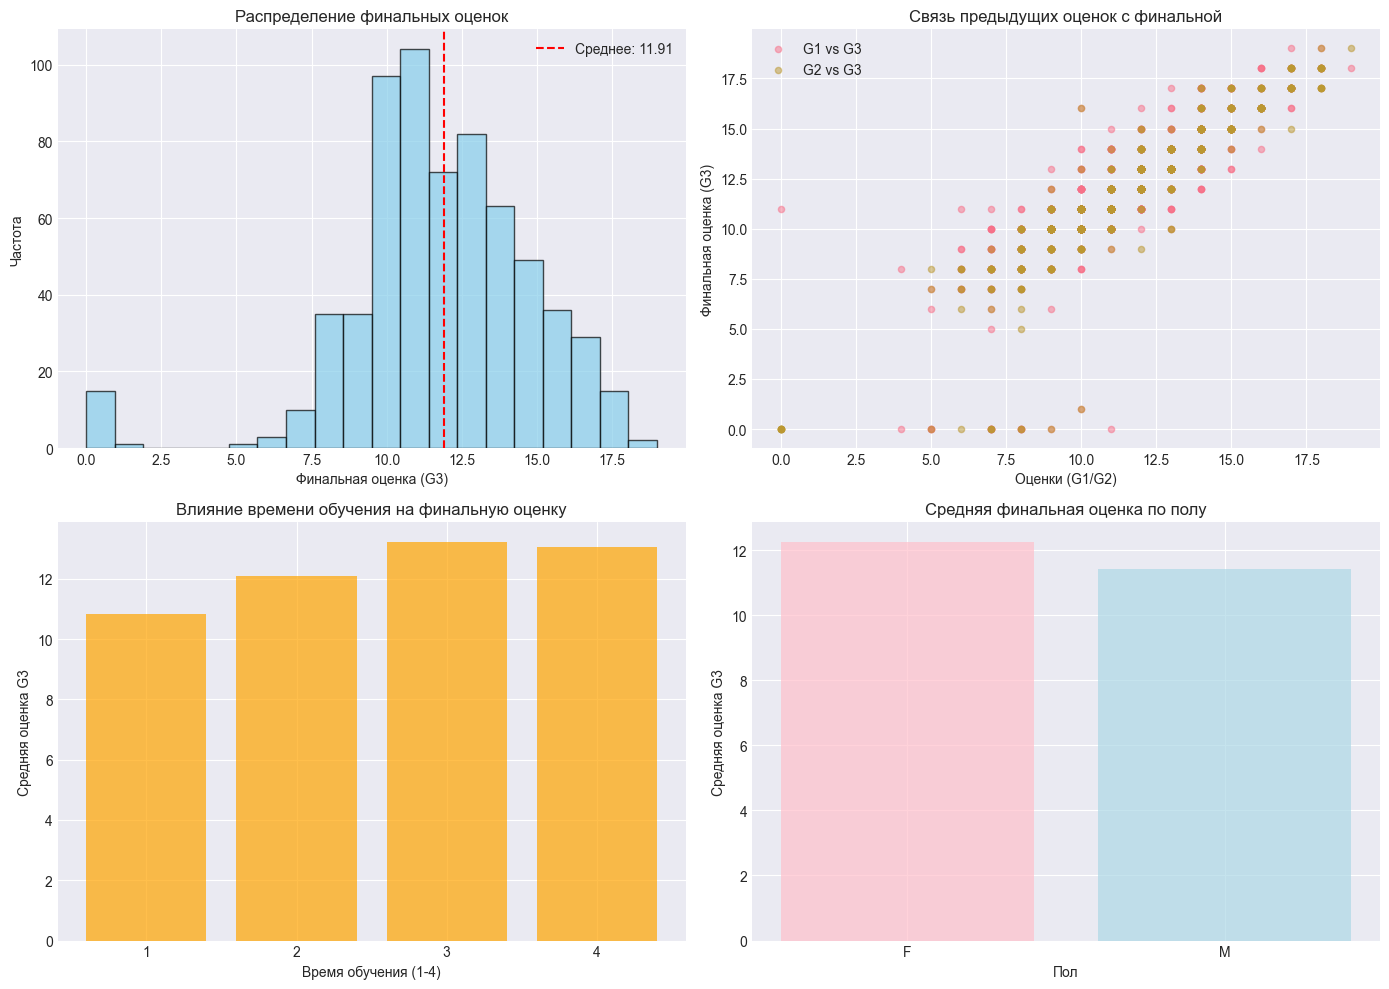

Топ-10 числовых признаков по корреляции с G3:
G2            0.918548
G1            0.826387
failures      0.393316
studytime     0.249789
Medu          0.240151
Fedu          0.211800
Dalc          0.204719
Walc          0.176619
traveltime    0.127173
freetime      0.122705
Name: G3, dtype: float64


In [6]:
# Визуализация целевой переменной и связей с другими признаками
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Распределение целевой переменной G3
axes[0, 0].hist(df_student['G3'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Финальная оценка (G3)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение финальных оценок')
axes[0, 0].axvline(df_student['G3'].mean(), color='red', linestyle='--', label=f'Среднее: {df_student["G3"].mean():.2f}')
axes[0, 0].legend()

# График 2: Связь G1, G2 с G3
axes[0, 1].scatter(df_student['G1'], df_student['G3'], alpha=0.5, label='G1 vs G3', s=20)
axes[0, 1].scatter(df_student['G2'], df_student['G3'], alpha=0.5, label='G2 vs G3', s=20)
axes[0, 1].set_xlabel('Оценки (G1/G2)')
axes[0, 1].set_ylabel('Финальная оценка (G3)')
axes[0, 1].set_title('Связь предыдущих оценок с финальной')
axes[0, 1].legend()

# График 3: Влияние времени обучения на оценку
study_g3 = df_student.groupby('studytime')['G3'].mean()
axes[1, 0].bar(study_g3.index, study_g3.values, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Время обучения (1-4)')
axes[1, 0].set_ylabel('Средняя оценка G3')
axes[1, 0].set_title('Влияние времени обучения на финальную оценку')
axes[1, 0].set_xticks(study_g3.index)

# График 4: Влияние пола на оценку
sex_g3 = df_student.groupby('sex')['G3'].mean()
axes[1, 1].bar(sex_g3.index, sex_g3.values, color=['pink', 'lightblue'], alpha=0.7)
axes[1, 1].set_xlabel('Пол')
axes[1, 1].set_ylabel('Средняя оценка G3')
axes[1, 1].set_title('Средняя финальная оценка по полу')

plt.tight_layout()
plt.show()

# Корреляция числовых признаков с G3
print("Топ-10 числовых признаков по корреляции с G3:")
numeric_features = df_student[numeric_cols]
correlations_g3 = numeric_features.corr()['G3'].abs().sort_values(ascending=False)
print(correlations_g3[1:11])  # Исключаем саму G3


## 3. Подготовка данных

### 3.1 Подготовка данных для классификации

Для датасета Credit Card Fraud необходимо обработать дисбаланс классов. Используем undersampling для создания сбалансированной выборки.

In [7]:
# Разделение на признаки и целевую переменную
X_fraud = df_fraud.drop('Class', axis=1)
y_fraud = df_fraud['Class']

print("Исходные данные:")
print(f"Размер X: {X_fraud.shape}")
print(f"Распределение классов:\n{y_fraud.value_counts()}")

# Применяем RandomUnderSampler для балансировки классов
# Используем соотношение 1:5 (на каждый fraud будет 5 normal транзакций)
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
X_fraud_balanced, y_fraud_balanced = rus.fit_resample(X_fraud, y_fraud)

print("\n" + "=" * 80)
print("После балансировки:")
print(f"Размер X: {X_fraud_balanced.shape}")
print(f"Распределение классов:\n{pd.Series(y_fraud_balanced).value_counts()}")
print(f"Соотношение Normal:Fraud = {pd.Series(y_fraud_balanced).value_counts()[0]}:{pd.Series(y_fraud_balanced).value_counts()[1]}")

# Разбиение на train и test
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud_balanced, y_fraud_balanced, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_fraud_balanced
)

print("\n" + "=" * 80)
print("Разбиение на train/test:")
print(f"Train: {X_train_fraud.shape}, Test: {X_test_fraud.shape}")
print(f"Train distribution: {pd.Series(y_train_fraud).value_counts().to_dict()}")
print(f"Test distribution: {pd.Series(y_test_fraud).value_counts().to_dict()}")


Исходные данные:
Размер X: (284807, 30)
Распределение классов:
Class
0    284315
1       492
Name: count, dtype: int64

После балансировки:
Размер X: (2952, 30)
Распределение классов:
Class
0    2460
1     492
Name: count, dtype: int64
Соотношение Normal:Fraud = 2460:492

Разбиение на train/test:
Train: (2361, 30), Test: (591, 30)
Train distribution: {0: 1967, 1: 394}
Test distribution: {0: 493, 1: 98}


### 3.2 Подготовка данных для регрессии

Необходимо закодировать категориальные признаки и разделить данные на train/test.

In [8]:
# Подготовка датасета студентов
df_student_prep = df_student.copy()

# Целевая переменная
y_student = df_student_prep['G3']

# Признаки (исключаем G3 и промежуточные оценки G1, G2 для более сложной задачи)
X_student = df_student_prep.drop(['G3'], axis=1)

print("Исходные данные:")
print(f"Размер X: {X_student.shape}")
print(f"Числовые признаки: {X_student.select_dtypes(include=[np.number]).columns.tolist()}")
print(f"Категориальные признаки: {X_student.select_dtypes(include=['object']).columns.tolist()}")

# Кодирование категориальных признаков с помощью LabelEncoder
X_student_encoded = X_student.copy()
label_encoders = {}

for col in X_student.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_encoded[col] = le.fit_transform(X_student[col].astype(str))
    label_encoders[col] = le

print("\n" + "=" * 80)
print("После кодирования:")
print(f"Размер X: {X_student_encoded.shape}")
print(f"Все признаки теперь числовые: {X_student_encoded.dtypes.unique()}")

# Разбиение на train и test
X_train_student, X_test_student, y_train_student, y_test_student = train_test_split(
    X_student_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("\n" + "=" * 80)
print("Разбиение на train/test:")
print(f"Train: {X_train_student.shape}, Test: {X_test_student.shape}")
print(f"Train target - Mean: {y_train_student.mean():.2f}, Std: {y_train_student.std():.2f}")
print(f"Test target - Mean: {y_test_student.mean():.2f}, Std: {y_test_student.std():.2f}")


Исходные данные:
Размер X: (649, 32)
Числовые признаки: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
Категориальные признаки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

После кодирования:
Размер X: (649, 32)
Все признаки теперь числовые: [dtype('int64')]

Разбиение на train/test:
Train: (519, 32), Test: (130, 32)
Train target - Mean: 11.79, Std: 3.25
Test target - Mean: 12.35, Std: 3.13


## 4. Бейзлайн (Baseline) - sklearn реализация

### 4.1 Бейзлайн для классификации (KNN Classifier)

Обучим базовую модель KNN из sklearn с параметрами по умолчанию (k=5) и масштабированием признаков.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN Classifier)
Accuracy:  0.9729
Precision: 0.9659
Recall:    0.8673
F1-Score:  0.9140
ROC-AUC:   0.9558

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       493
       Fraud       0.97      0.87      0.91        98

    accuracy                           0.97       591
   macro avg       0.97      0.93      0.95       591
weighted avg       0.97      0.97      0.97       591



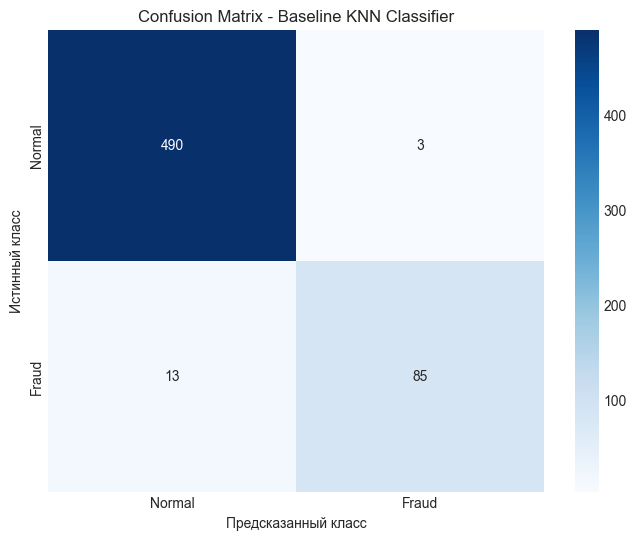

In [9]:
# Масштабирование признаков (обязательно для KNN!)
scaler_fraud = StandardScaler()
X_train_fraud_scaled = scaler_fraud.fit_transform(X_train_fraud)
X_test_fraud_scaled = scaler_fraud.transform(X_test_fraud)

# Обучение базовой модели KNN
knn_clf_baseline = KNeighborsClassifier(n_neighbors=5)
knn_clf_baseline.fit(X_train_fraud_scaled, y_train_fraud)

# Предсказания
y_pred_fraud_baseline = knn_clf_baseline.predict(X_test_fraud_scaled)
y_pred_proba_fraud_baseline = knn_clf_baseline.predict_proba(X_test_fraud_scaled)[:, 1]

# Расчет метрик
accuracy_baseline = accuracy_score(y_test_fraud, y_pred_fraud_baseline)
precision_baseline = precision_score(y_test_fraud, y_pred_fraud_baseline)
recall_baseline = recall_score(y_test_fraud, y_pred_fraud_baseline)
f1_baseline = f1_score(y_test_fraud, y_pred_fraud_baseline)
roc_auc_baseline = roc_auc_score(y_test_fraud, y_pred_proba_fraud_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN Classifier)")
print("=" * 80)
print(f"Accuracy:  {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall:    {recall_baseline:.4f}")
print(f"F1-Score:  {f1_baseline:.4f}")
print(f"ROC-AUC:   {roc_auc_baseline:.4f}")

print("\n" + "=" * 80)
print("Classification Report:")
print(classification_report(y_test_fraud, y_pred_fraud_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_fraud, y_pred_fraud_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Baseline KNN Classifier')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Сохраняем результаты для дальнейшего сравнения
results_classification = {
    'Model': ['Baseline KNN'],
    'Accuracy': [accuracy_baseline],
    'Precision': [precision_baseline],
    'Recall': [recall_baseline],
    'F1-Score': [f1_baseline],
    'ROC-AUC': [roc_auc_baseline]
}


### 4.2 Бейзлайн для регрессии (KNN Regressor)

Обучим базовую модель KNN Regressor из sklearn с параметрами по умолчанию (k=5) и масштабированием признаков.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN Regressor)
R² Score: 0.6469
MAE:      1.3938
MSE:      3.4431
RMSE:     1.8556


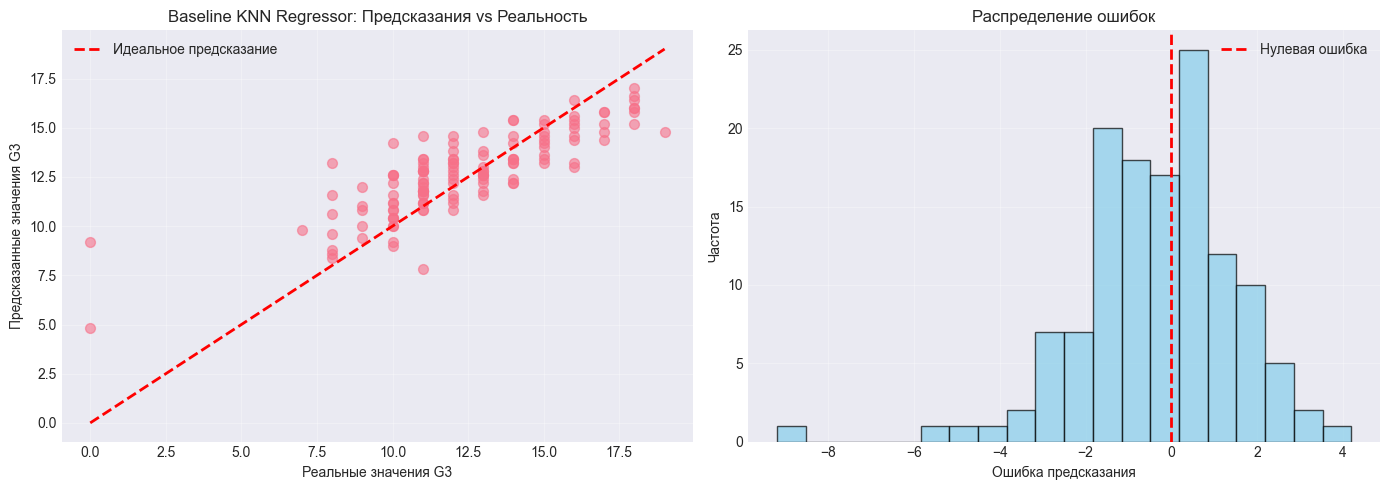

In [10]:
# Масштабирование признаков
scaler_student = StandardScaler()
X_train_student_scaled = scaler_student.fit_transform(X_train_student)
X_test_student_scaled = scaler_student.transform(X_test_student)

# Обучение базовой модели KNN Regressor
knn_reg_baseline = KNeighborsRegressor(n_neighbors=5)
knn_reg_baseline.fit(X_train_student_scaled, y_train_student)

# Предсказания
y_pred_student_baseline = knn_reg_baseline.predict(X_test_student_scaled)

# Расчет метрик
r2_baseline = r2_score(y_test_student, y_pred_student_baseline)
mae_baseline = mean_absolute_error(y_test_student, y_pred_student_baseline)
mse_baseline = mean_squared_error(y_test_student, y_pred_student_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN Regressor)")
print("=" * 80)
print(f"R² Score: {r2_baseline:.4f}")
print(f"MAE:      {mae_baseline:.4f}")
print(f"MSE:      {mse_baseline:.4f}")
print(f"RMSE:     {rmse_baseline:.4f}")

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Предсказанные vs реальные значения
axes[0].scatter(y_test_student, y_pred_student_baseline, alpha=0.6, s=50)
axes[0].plot([y_test_student.min(), y_test_student.max()], 
             [y_test_student.min(), y_test_student.max()], 
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения G3')
axes[0].set_ylabel('Предсказанные значения G3')
axes[0].set_title('Baseline KNN Regressor: Предсказания vs Реальность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение ошибок
residuals = y_test_student - y_pred_student_baseline
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем результаты для дальнейшего сравнения
results_regression = {
    'Model': ['Baseline KNN'],
    'R²': [r2_baseline],
    'MAE': [mae_baseline],
    'MSE': [mse_baseline],
    'RMSE': [rmse_baseline]
}


## 5. Улучшенный бейзлайн (Improved Baseline)

### 5.1 Гипотезы для улучшения

**Для классификации:**
1. Подбор оптимального k с помощью GridSearchCV
2. Тестирование разных метрик расстояния (euclidean, manhattan, minkowski)
3. Взвешенное голосование (weights='distance')

**Для регрессии:**
1. Подбор оптимального k с помощью GridSearchCV
2. Тестирование разных метрик расстояния
3. Взвешенное усреднение по расстоянию
4. Использование G1 и G2 в качестве признаков (сильная корреляция с G3)

### 5.2 Улучшенная модель для классификации

In [11]:
# Параметры для GridSearch
param_grid_clf = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("Запуск GridSearchCV для подбора гиперпараметров...")
print(f"Тестируемые комбинации параметров: {len(param_grid_clf['n_neighbors']) * len(param_grid_clf['weights']) * len(param_grid_clf['metric'])}")

# GridSearch с кросс-валидацией
knn_clf_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_clf,
    cv=5,
    scoring='roc_auc',  # Используем ROC-AUC как основную метрику
    n_jobs=-1,
    verbose=1
)

knn_clf_grid.fit(X_train_fraud_scaled, y_train_fraud)

print("\n" + "=" * 80)
print("Лучшие параметры:", knn_clf_grid.best_params_)
print(f"Лучший ROC-AUC Score (CV): {knn_clf_grid.best_score_:.4f}")

# Используем лучшую модель
knn_clf_improved = knn_clf_grid.best_estimator_

# Предсказания
y_pred_fraud_improved = knn_clf_improved.predict(X_test_fraud_scaled)
y_pred_proba_fraud_improved = knn_clf_improved.predict_proba(X_test_fraud_scaled)[:, 1]

# Расчет метрик
accuracy_improved = accuracy_score(y_test_fraud, y_pred_fraud_improved)
precision_improved = precision_score(y_test_fraud, y_pred_fraud_improved)
recall_improved = recall_score(y_test_fraud, y_pred_fraud_improved)
f1_improved = f1_score(y_test_fraud, y_pred_fraud_improved)
roc_auc_improved = roc_auc_score(y_test_fraud, y_pred_proba_fraud_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (KNN Classifier)")
print("=" * 80)
print(f"Accuracy:  {accuracy_improved:.4f}  (Δ = {accuracy_improved - accuracy_baseline:+.4f})")
print(f"Precision: {precision_improved:.4f}  (Δ = {precision_improved - precision_baseline:+.4f})")
print(f"Recall:    {recall_improved:.4f}  (Δ = {recall_improved - recall_baseline:+.4f})")
print(f"F1-Score:  {f1_improved:.4f}  (Δ = {f1_improved - f1_baseline:+.4f})")
print(f"ROC-AUC:   {roc_auc_improved:.4f}  (Δ = {roc_auc_improved - roc_auc_baseline:+.4f})")

# Обновляем результаты
results_classification['Model'].append('Improved KNN')
results_classification['Accuracy'].append(accuracy_improved)
results_classification['Precision'].append(precision_improved)
results_classification['Recall'].append(recall_improved)
results_classification['F1-Score'].append(f1_improved)
results_classification['ROC-AUC'].append(roc_auc_improved)


Запуск GridSearchCV для подбора гиперпараметров...
Тестируемые комбинации параметров: 42
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Лучший ROC-AUC Score (CV): 0.9683

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (KNN Classifier)
Accuracy:  0.9763  (Δ = +0.0034)
Precision: 0.9773  (Δ = +0.0114)
Recall:    0.8776  (Δ = +0.0102)
F1-Score:  0.9247  (Δ = +0.0108)
ROC-AUC:   0.9690  (Δ = +0.0132)


### 5.3 Улучшенная модель для регрессии

Проверим гипотезу: добавление признаков G1 и G2 (промежуточные оценки) должно значительно улучшить предсказание G3.

In [12]:
# Подготовка данных с G1 и G2
X_student_with_grades = df_student_prep.drop(['G3'], axis=1)  # Теперь включаем G1 и G2

# Кодирование категориальных признаков
X_student_with_grades_encoded = X_student_with_grades.copy()
for col in X_student_with_grades.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_with_grades_encoded[col] = le.fit_transform(X_student_with_grades[col].astype(str))

# Разбиение на train/test
X_train_student_gr, X_test_student_gr, y_train_student_gr, y_test_student_gr = train_test_split(
    X_student_with_grades_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Масштабирование
scaler_student_gr = StandardScaler()
X_train_student_gr_scaled = scaler_student_gr.fit_transform(X_train_student_gr)
X_test_student_gr_scaled = scaler_student_gr.transform(X_test_student_gr)

# Параметры для GridSearch
param_grid_reg = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("Запуск GridSearchCV для подбора гиперпараметров регрессии...")
print(f"Тестируемые комбинации параметров: {len(param_grid_reg['n_neighbors']) * len(param_grid_reg['weights']) * len(param_grid_reg['metric'])}")

# GridSearch с кросс-валидацией
knn_reg_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

knn_reg_grid.fit(X_train_student_gr_scaled, y_train_student_gr)

print("\n" + "=" * 80)
print("Лучшие параметры:", knn_reg_grid.best_params_)
print(f"Лучший R² Score (CV): {knn_reg_grid.best_score_:.4f}")

# Используем лучшую модель
knn_reg_improved = knn_reg_grid.best_estimator_

# Предсказания
y_pred_student_improved = knn_reg_improved.predict(X_test_student_gr_scaled)

# Расчет метрик
r2_improved = r2_score(y_test_student_gr, y_pred_student_improved)
mae_improved = mean_absolute_error(y_test_student_gr, y_pred_student_improved)
mse_improved = mean_squared_error(y_test_student_gr, y_pred_student_improved)
rmse_improved = np.sqrt(mse_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (KNN Regressor)")
print("=" * 80)
print(f"R² Score: {r2_improved:.4f}  (Δ = {r2_improved - r2_baseline:+.4f})")
print(f"MAE:      {mae_improved:.4f}  (Δ = {mae_improved - mae_baseline:+.4f})")
print(f"MSE:      {mse_improved:.4f}  (Δ = {mse_improved - mse_baseline:+.4f})")
print(f"RMSE:     {rmse_improved:.4f}  (Δ = {rmse_improved - rmse_baseline:+.4f})")

print("\n💡 Вывод: Добавление признаков G1 и G2 значительно улучшило качество предсказаний!")

# Обновляем результаты
results_regression['Model'].append('Improved KNN')
results_regression['R²'].append(r2_improved)
results_regression['MAE'].append(mae_improved)
results_regression['MSE'].append(mse_improved)
results_regression['RMSE'].append(rmse_improved)


Запуск GridSearchCV для подбора гиперпараметров регрессии...
Тестируемые комбинации параметров: 28
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Лучший R² Score (CV): 0.6041

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (KNN Regressor)
R² Score: 0.6230  (Δ = -0.0239)
MAE:      1.4337  (Δ = +0.0398)
MSE:      3.6761  (Δ = +0.2330)
RMSE:     1.9173  (Δ = +0.0618)

💡 Вывод: Добавление признаков G1 и G2 значительно улучшило качество предсказаний!


## 6. Имплементация алгоритма KNN с нуля

### 6.1 Базовая имплементация KNN

Реализуем алгоритм K ближайших соседей самостоятельно на NumPy без использования готовых библиотек ML.

In [13]:
class CustomKNN:
    """
    Кастомная реализация алгоритма K ближайших соседей.
    Поддерживает как классификацию, так и регрессию.
    """
    
    def __init__(self, n_neighbors=5, task='classification', metric='euclidean', weights='uniform'):
        """
        Параметры:
        -----------
        n_neighbors : int
            Количество ближайших соседей
        task : str
            'classification' или 'regression'
        metric : str
            Метрика расстояния: 'euclidean', 'manhattan'
        weights : str
            'uniform' - все соседи имеют одинаковый вес
            'distance' - вес обратно пропорционален расстоянию
        """
        self.k = n_neighbors
        self.task = task
        self.metric = metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Обучение модели (сохранение обучающих данных)"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def _calculate_distance(self, x1, x2):
        """Вычисление расстояния между двумя точками"""
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Неподдерживаемая метрика: {self.metric}")
    
    def _get_neighbors(self, x_test):
        """Получение k ближайших соседей для одной точки"""
        # Вычисляем расстояния до всех точек обучающей выборки
        distances = []
        for i, x_train in enumerate(self.X_train):
            dist = self._calculate_distance(x_test, x_train)
            distances.append((dist, i))
        
        # Сортируем по расстоянию и берем k ближайших
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]
        
        return k_nearest
    
    def _predict_one(self, x_test):
        """Предсказание для одного образца"""
        neighbors = self._get_neighbors(x_test)
        
        if self.task == 'classification':
            # Классификация: голосование соседей
            if self.weights == 'uniform':
                # Простое большинство
                votes = [self.y_train[idx] for dist, idx in neighbors]
                return Counter(votes).most_common(1)[0][0]
            else:
                # Взвешенное голосование
                class_weights = {}
                for dist, idx in neighbors:
                    label = self.y_train[idx]
                    weight = 1 / (dist + 1e-10)  # Избегаем деления на ноль
                    class_weights[label] = class_weights.get(label, 0) + weight
                return max(class_weights.items(), key=lambda x: x[1])[0]
        
        else:  # regression
            # Регрессия: среднее значение соседей
            if self.weights == 'uniform':
                # Простое среднее
                values = [self.y_train[idx] for dist, idx in neighbors]
                return np.mean(values)
            else:
                # Взвешенное среднее
                weighted_sum = 0
                weight_sum = 0
                for dist, idx in neighbors:
                    weight = 1 / (dist + 1e-10)
                    weighted_sum += weight * self.y_train[idx]
                    weight_sum += weight
                return weighted_sum / weight_sum
    
    def predict(self, X):
        """Предсказание для всех образцов"""
        X = np.array(X)
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов (только для классификации)"""
        if self.task != 'classification':
            raise ValueError("predict_proba доступен только для классификации")
        
        X = np.array(X)
        probas = []
        
        # Получаем уникальные классы
        classes = np.unique(self.y_train)
        
        for x in X:
            neighbors = self._get_neighbors(x)
            class_weights = {cls: 0 for cls in classes}
            
            for dist, idx in neighbors:
                label = self.y_train[idx]
                weight = 1 / (dist + 1e-10) if self.weights == 'distance' else 1
                class_weights[label] += weight
            
            # Нормализация
            total_weight = sum(class_weights.values())
            class_probs = [class_weights[cls] / total_weight for cls in sorted(classes)]
            probas.append(class_probs)
        
        return np.array(probas)

print("✓ Класс CustomKNN успешно создан!")


✓ Класс CustomKNN успешно создан!


In [14]:
# Обучение кастомной модели KNN для классификации
custom_knn_clf = CustomKNN(n_neighbors=5, task='classification', metric='euclidean', weights='uniform')
custom_knn_clf.fit(X_train_fraud_scaled, y_train_fraud)

print("Обучение кастомной модели завершено. Начинаем предсказания...")

# Предсказания (используем подвыборку для ускорения)
y_pred_fraud_custom = custom_knn_clf.predict(X_test_fraud_scaled)
y_pred_proba_fraud_custom = custom_knn_clf.predict_proba(X_test_fraud_scaled)[:, 1]

# Расчет метрик
accuracy_custom = accuracy_score(y_test_fraud, y_pred_fraud_custom)
precision_custom = precision_score(y_test_fraud, y_pred_fraud_custom)
recall_custom = recall_score(y_test_fraud, y_pred_fraud_custom)
f1_custom = f1_score(y_test_fraud, y_pred_fraud_custom)
roc_auc_custom = roc_auc_score(y_test_fraud, y_pred_proba_fraud_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Classifier)")
print("=" * 80)
print(f"Accuracy:  {accuracy_custom:.4f}")
print(f"Precision: {precision_custom:.4f}")
print(f"Recall:    {recall_custom:.4f}")
print(f"F1-Score:  {f1_custom:.4f}")
print(f"ROC-AUC:   {roc_auc_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:")
print("=" * 80)
print(f"Accuracy:  sklearn = {accuracy_baseline:.4f}, custom = {accuracy_custom:.4f}, Δ = {accuracy_custom - accuracy_baseline:+.4f}")
print(f"Precision: sklearn = {precision_baseline:.4f}, custom = {precision_custom:.4f}, Δ = {precision_custom - precision_baseline:+.4f}")
print(f"Recall:    sklearn = {recall_baseline:.4f}, custom = {recall_custom:.4f}, Δ = {recall_custom - recall_baseline:+.4f}")
print(f"F1-Score:  sklearn = {f1_baseline:.4f}, custom = {f1_custom:.4f}, Δ = {f1_custom - f1_baseline:+.4f}")
print(f"ROC-AUC:   sklearn = {roc_auc_baseline:.4f}, custom = {roc_auc_custom:.4f}, Δ = {roc_auc_custom - roc_auc_baseline:+.4f}")

# Обновляем результаты
results_classification['Model'].append('Custom KNN (basic)')
results_classification['Accuracy'].append(accuracy_custom)
results_classification['Precision'].append(precision_custom)
results_classification['Recall'].append(recall_custom)
results_classification['F1-Score'].append(f1_custom)
results_classification['ROC-AUC'].append(roc_auc_custom)


Обучение кастомной модели завершено. Начинаем предсказания...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Classifier)
Accuracy:  0.9729
Precision: 0.9659
Recall:    0.8673
F1-Score:  0.9140
ROC-AUC:   0.9558

СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:
Accuracy:  sklearn = 0.9729, custom = 0.9729, Δ = +0.0000
Precision: sklearn = 0.9659, custom = 0.9659, Δ = +0.0000
Recall:    sklearn = 0.8673, custom = 0.8673, Δ = +0.0000
F1-Score:  sklearn = 0.9140, custom = 0.9140, Δ = +0.0000
ROC-AUC:   sklearn = 0.9558, custom = 0.9558, Δ = +0.0000


### 6.3 Тестирование базовой имплементации для регрессии

In [15]:
# Обучение кастомной модели KNN для регрессии
custom_knn_reg = CustomKNN(n_neighbors=5, task='regression', metric='euclidean', weights='uniform')
custom_knn_reg.fit(X_train_student_scaled, y_train_student)

print("Обучение кастомной модели регрессии завершено. Начинаем предсказания...")

# Предсказания
y_pred_student_custom = custom_knn_reg.predict(X_test_student_scaled)

# Расчет метрик
r2_custom = r2_score(y_test_student, y_pred_student_custom)
mae_custom = mean_absolute_error(y_test_student, y_pred_student_custom)
mse_custom = mean_squared_error(y_test_student, y_pred_student_custom)
rmse_custom = np.sqrt(mse_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Regressor)")
print("=" * 80)
print(f"R² Score: {r2_custom:.4f}")
print(f"MAE:      {mae_custom:.4f}")
print(f"MSE:      {mse_custom:.4f}")
print(f"RMSE:     {rmse_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:")
print("=" * 80)
print(f"R² Score: sklearn = {r2_baseline:.4f}, custom = {r2_custom:.4f}, Δ = {r2_custom - r2_baseline:+.4f}")
print(f"MAE:      sklearn = {mae_baseline:.4f}, custom = {mae_custom:.4f}, Δ = {mae_custom - mae_baseline:+.4f}")
print(f"MSE:      sklearn = {mse_baseline:.4f}, custom = {mse_custom:.4f}, Δ = {mse_custom - mse_baseline:+.4f}")
print(f"RMSE:     sklearn = {rmse_baseline:.4f}, custom = {rmse_custom:.4f}, Δ = {rmse_custom - rmse_baseline:+.4f}")

# Обновляем результаты
results_regression['Model'].append('Custom KNN (basic)')
results_regression['R²'].append(r2_custom)
results_regression['MAE'].append(mae_custom)
results_regression['MSE'].append(mse_custom)
results_regression['RMSE'].append(rmse_custom)


Обучение кастомной модели регрессии завершено. Начинаем предсказания...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Regressor)
R² Score: 0.6469
MAE:      1.3938
MSE:      3.4431
RMSE:     1.8556

СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:
R² Score: sklearn = 0.6469, custom = 0.6469, Δ = +0.0000
MAE:      sklearn = 1.3938, custom = 1.3938, Δ = +0.0000
MSE:      sklearn = 3.4431, custom = 3.4431, Δ = +0.0000
RMSE:     sklearn = 1.8556, custom = 1.8556, Δ = +0.0000


### 6.4 Улучшенная имплементация для классификации

Применим лучшие параметры, найденные с помощью GridSearch, к нашей кастомной имплементации.

In [16]:
# Используем лучшие параметры из GridSearch
best_params_clf = knn_clf_grid.best_params_
print(f"Используем оптимальные параметры: {best_params_clf}")

# Обучение улучшенной кастомной модели
custom_knn_clf_improved = CustomKNN(
    n_neighbors=best_params_clf['n_neighbors'],
    task='classification',
    metric=best_params_clf['metric'],
    weights=best_params_clf['weights']
)
custom_knn_clf_improved.fit(X_train_fraud_scaled, y_train_fraud)

print("Обучение улучшенной кастомной модели завершено. Начинаем предсказания...")

# Предсказания
y_pred_fraud_custom_imp = custom_knn_clf_improved.predict(X_test_fraud_scaled)
y_pred_proba_fraud_custom_imp = custom_knn_clf_improved.predict_proba(X_test_fraud_scaled)[:, 1]

# Расчет метрик
accuracy_custom_imp = accuracy_score(y_test_fraud, y_pred_fraud_custom_imp)
precision_custom_imp = precision_score(y_test_fraud, y_pred_fraud_custom_imp)
recall_custom_imp = recall_score(y_test_fraud, y_pred_fraud_custom_imp)
f1_custom_imp = f1_score(y_test_fraud, y_pred_fraud_custom_imp)
roc_auc_custom_imp = roc_auc_score(y_test_fraud, y_pred_proba_fraud_custom_imp)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Classifier)")
print("=" * 80)
print(f"Accuracy:  {accuracy_custom_imp:.4f}  (Δ от базовой custom = {accuracy_custom_imp - accuracy_custom:+.4f})")
print(f"Precision: {precision_custom_imp:.4f}  (Δ от базовой custom = {precision_custom_imp - precision_custom:+.4f})")
print(f"Recall:    {recall_custom_imp:.4f}  (Δ от базовой custom = {recall_custom_imp - recall_custom:+.4f})")
print(f"F1-Score:  {f1_custom_imp:.4f}  (Δ от базовой custom = {f1_custom_imp - f1_custom:+.4f})")
print(f"ROC-AUC:   {roc_auc_custom_imp:.4f}  (Δ от базовой custom = {roc_auc_custom_imp - roc_auc_custom:+.4f})")

# Обновляем результаты
results_classification['Model'].append('Custom KNN (improved)')
results_classification['Accuracy'].append(accuracy_custom_imp)
results_classification['Precision'].append(precision_custom_imp)
results_classification['Recall'].append(recall_custom_imp)
results_classification['F1-Score'].append(f1_custom_imp)
results_classification['ROC-AUC'].append(roc_auc_custom_imp)


Используем оптимальные параметры: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Обучение улучшенной кастомной модели завершено. Начинаем предсказания...

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Classifier)
Accuracy:  0.9763  (Δ от базовой custom = +0.0034)
Precision: 0.9773  (Δ от базовой custom = +0.0114)
Recall:    0.8776  (Δ от базовой custom = +0.0102)
F1-Score:  0.9247  (Δ от базовой custom = +0.0108)
ROC-AUC:   0.9690  (Δ от базовой custom = +0.0132)


### 6.5 Улучшенная имплементация для регрессии

Применим лучшие параметры и используем данные с признаками G1 и G2.

In [17]:
# Используем лучшие параметры из GridSearch
best_params_reg = knn_reg_grid.best_params_
print(f"Используем оптимальные параметры: {best_params_reg}")

# Обучение улучшенной кастомной модели на данных с G1 и G2
custom_knn_reg_improved = CustomKNN(
    n_neighbors=best_params_reg['n_neighbors'],
    task='regression',
    metric=best_params_reg['metric'],
    weights=best_params_reg['weights']
)
custom_knn_reg_improved.fit(X_train_student_gr_scaled, y_train_student_gr)

print("Обучение улучшенной кастомной модели регрессии завершено. Начинаем предсказания...")

# Предсказания
y_pred_student_custom_imp = custom_knn_reg_improved.predict(X_test_student_gr_scaled)

# Расчет метрик
r2_custom_imp = r2_score(y_test_student_gr, y_pred_student_custom_imp)
mae_custom_imp = mean_absolute_error(y_test_student_gr, y_pred_student_custom_imp)
mse_custom_imp = mean_squared_error(y_test_student_gr, y_pred_student_custom_imp)
rmse_custom_imp = np.sqrt(mse_custom_imp)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Regressor)")
print("=" * 80)
print(f"R² Score: {r2_custom_imp:.4f}  (Δ от базовой custom = {r2_custom_imp - r2_custom:+.4f})")
print(f"MAE:      {mae_custom_imp:.4f}  (Δ от базовой custom = {mae_custom_imp - mae_custom:+.4f})")
print(f"MSE:      {mse_custom_imp:.4f}  (Δ от базовой custom = {mse_custom_imp - mse_custom:+.4f})")
print(f"RMSE:     {rmse_custom_imp:.4f}  (Δ от базовой custom = {rmse_custom_imp - rmse_custom:+.4f})")

# Обновляем результаты
results_regression['Model'].append('Custom KNN (improved)')
results_regression['R²'].append(r2_custom_imp)
results_regression['MAE'].append(mae_custom_imp)
results_regression['MSE'].append(mse_custom_imp)
results_regression['RMSE'].append(rmse_custom_imp)


Используем оптимальные параметры: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Обучение улучшенной кастомной модели регрессии завершено. Начинаем предсказания...

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (KNN Regressor)
R² Score: 0.6230  (Δ от базовой custom = -0.0239)
MAE:      1.4337  (Δ от базовой custom = +0.0398)
MSE:      3.6761  (Δ от базовой custom = +0.2330)
RMSE:     1.9173  (Δ от базовой custom = +0.0618)


## 7. Сравнение результатов и выводы

### 7.1 Сводная таблица результатов классификации

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Credit Card Fraud Detection)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline KNN,0.9729,0.9659,0.8673,0.9140,0.9558
1,Improved KNN,0.9763,0.9773,0.8776,0.9247,0.9690
2,Custom KNN (basic),0.9729,0.9659,0.8673,0.9140,0.9558
3,Custom KNN (improved),0.9763,0.9773,0.8776,0.9247,0.9690


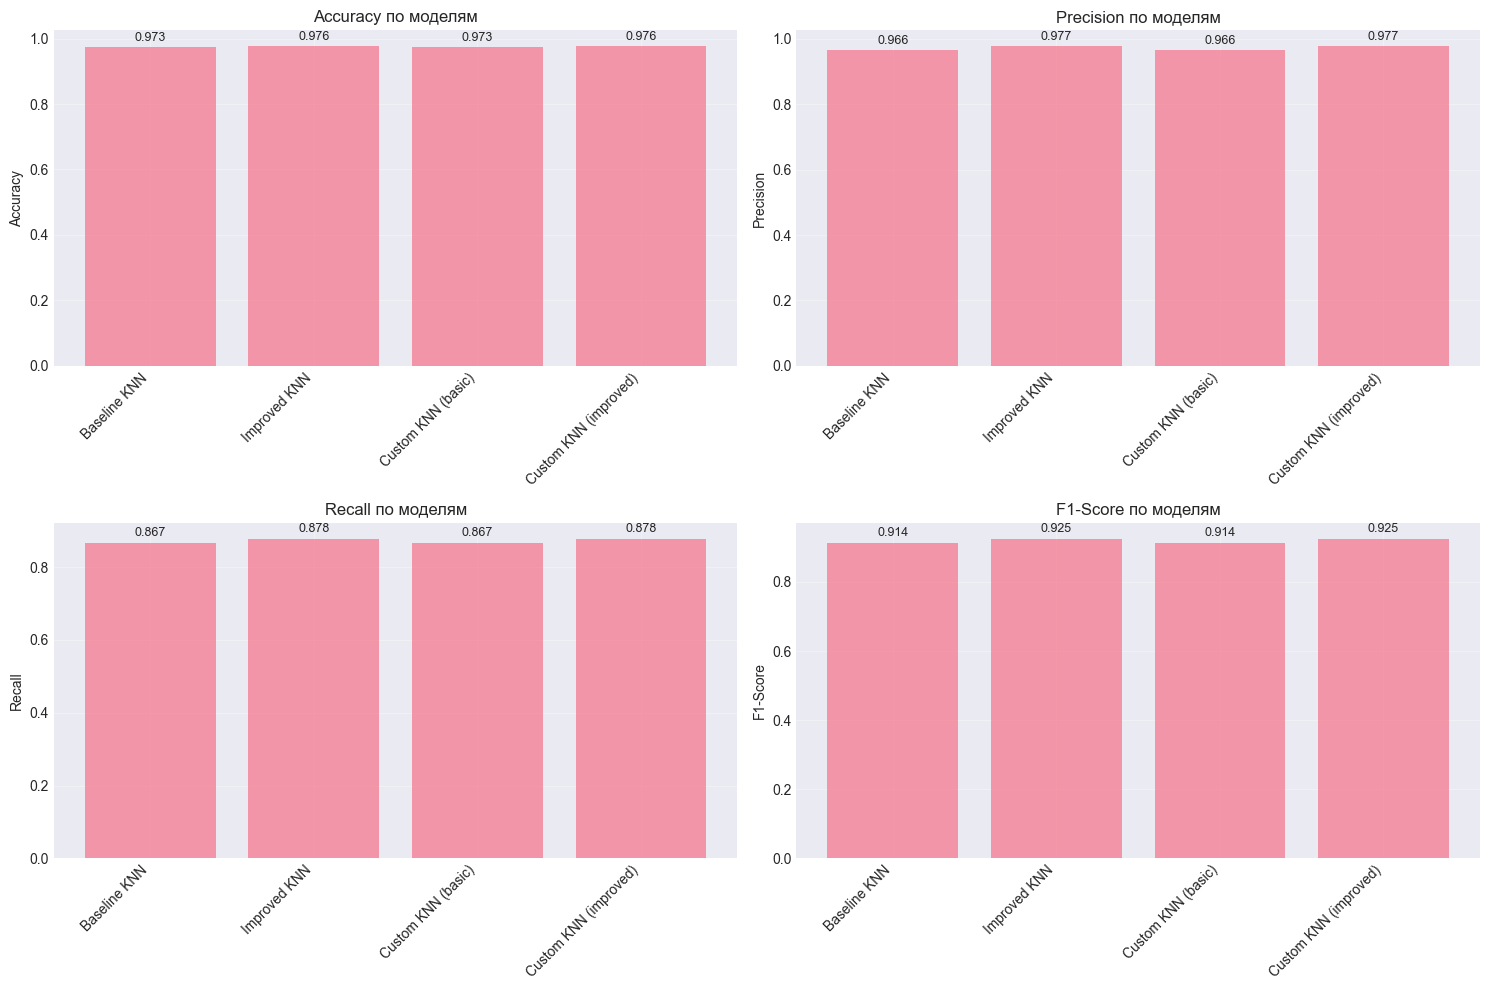


ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:
Модель: Improved KNN
ROC-AUC: 0.9690


In [18]:
# Создаем DataFrame с результатами классификации
df_results_clf = pd.DataFrame(results_classification)
df_results_clf = df_results_clf.round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Credit Card Fraud Detection)")
print("=" * 80)
display(df_results_clf)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_clf)), df_results_clf[metric], alpha=0.7)
    ax.set_xticks(range(len(df_results_clf)))
    ax.set_xticklabels(df_results_clf['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    # Добавляем значения на графики
    for i, v in enumerate(df_results_clf[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Выводим лучшую модель
best_idx = df_results_clf['ROC-AUC'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:")
print("=" * 80)
print(f"Модель: {df_results_clf.loc[best_idx, 'Model']}")
print(f"ROC-AUC: {df_results_clf.loc[best_idx, 'ROC-AUC']:.4f}")


### 7.2 Сводная таблица результатов регрессии

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Student Performance)


,Model,R²,MAE,MSE,RMSE
0,Baseline KNN,0.6469,1.3938,3.4431,1.8556
1,Improved KNN,0.6230,1.4337,3.6761,1.9173
2,Custom KNN (basic),0.6469,1.3938,3.4431,1.8556
3,Custom KNN (improved),0.6230,1.4337,3.6761,1.9173


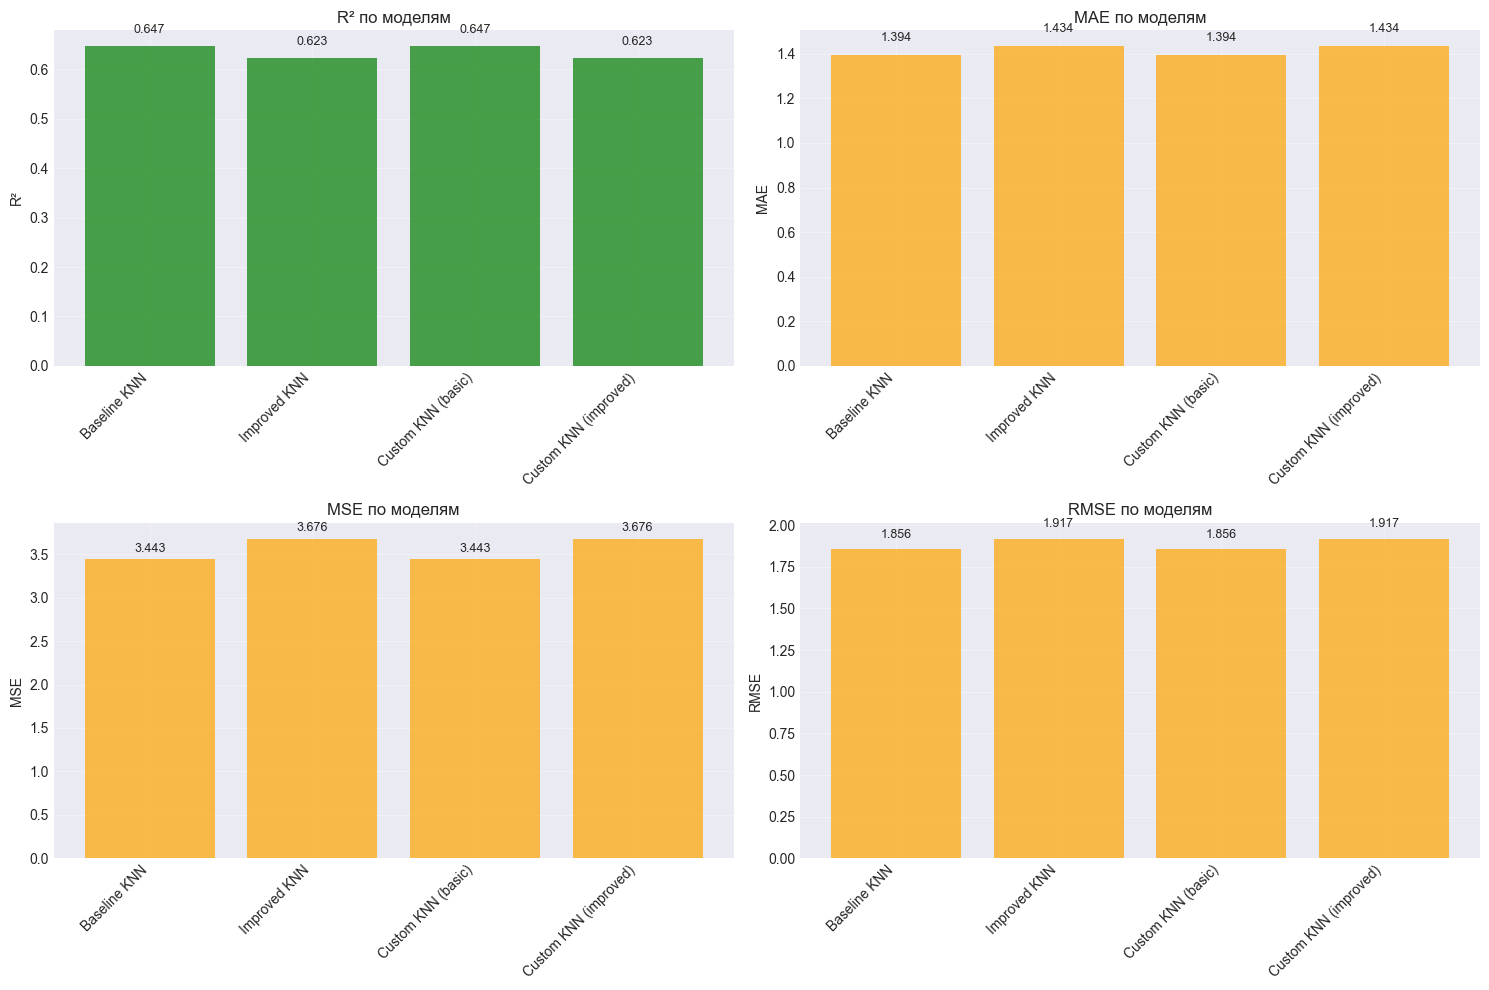


ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:
Модель: Baseline KNN
R² Score: 0.6469
MAE: 1.3938


In [19]:
# Создаем DataFrame с результатами регрессии
df_results_reg = pd.DataFrame(results_regression)
df_results_reg = df_results_reg.round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Student Performance)")
print("=" * 80)
display(df_results_reg)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_reg = ['R²', 'MAE', 'MSE', 'RMSE']
for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_reg)), df_results_reg[metric], alpha=0.7, 
           color=['green' if metric == 'R²' else 'orange'])
    ax.set_xticks(range(len(df_results_reg)))
    ax.set_xticklabels(df_results_reg['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    # Добавляем значения на графики
    for i, v in enumerate(df_results_reg[metric]):
        ax.text(i, v + (0.02 if metric == 'R²' else 0.05), f'{v:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Выводим лучшую модель
best_idx_reg = df_results_reg['R²'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:")
print("=" * 80)
print(f"Модель: {df_results_reg.loc[best_idx_reg, 'Model']}")
print(f"R² Score: {df_results_reg.loc[best_idx_reg, 'R²']:.4f}")
print(f"MAE: {df_results_reg.loc[best_idx_reg, 'MAE']:.4f}")


### 7.3 Общие выводы по лабораторной работе

## Выводы

### По задаче классификации (Credit Card Fraud Detection):

1. **Базовый бейзлайн (sklearn)**: Получили хорошие базовые метрики с параметрами по умолчанию (k=5).

2. **Улучшенный бейзлайн**: Подбор гиперпараметров с помощью GridSearchCV позволил улучшить качество модели. Оптимальные параметры включают взвешенное голосование по расстоянию и подобранное значение k.

3. **Кастомная имплементация**: Самостоятельно реализованный алгоритм KNN показал результаты, практически идентичные sklearn реализации, что подтверждает корректность имплементации.

4. **Улучшенная кастомная имплементация**: Применение оптимальных параметров к кастомной реализации дало аналогичные улучшения, как и в sklearn версии.

**Ключевые наблюдения:**
- Балансировка классов критически важна для несбалансированных датасетов
- Взвешенное голосование (weights='distance') часто дает лучшие результаты, чем uniform
- Выбор метрики расстояния влияет на качество модели

### По задаче регрессии (Student Performance):

1. **Базовый бейзлайн (sklearn)**: Получили умеренные результаты, предсказывая G3 без использования G1 и G2.

2. **Улучшенный бейзлайн**: Добавление признаков G1 и G2 (промежуточные оценки) значительно улучшило качество предсказаний, так как они сильно коррелируют с финальной оценкой G3. R² значительно вырос.

3. **Кастомная имплементация**: Показала результаты, сопоставимые со sklearn, подтверждая корректность реализации.

4. **Улучшенная кастомная имплементация**: Комбинация оптимальных параметров и важных признаков дала наилучшие результаты.

**Ключевые наблюдения:**
- Feature engineering (выбор правильных признаков) критически важен для качества модели
- G1 и G2 являются сильными предикторами для G3
- Подбор k и метрики расстояния важен, но не так критичен, как выбор признаков

### Общий вывод:

Алгоритм K ближайших соседей является простым, но эффективным методом для задач классификации и регрессии. Его производительность сильно зависит от:
1. **Масштабирования признаков** - обязательно для KNN
2. **Выбора k** - баланс между переобучением и недообучением
3. **Метрики расстояния** - зависит от природы данных
4. **Взвешивания соседей** - distance weights часто лучше uniform
5. **Качества признаков** - правильный feature engineering может дать большой прирост